# Similar.AI Data Preparation

**Dataset**

To label data with Similar.AI labels, we have pre-processed the StreetStyle-27K dataset. The dataset includes images from the wild/Instagram, gathered from the Flickr 100M dataset. 

In [5]:
#loading data for the duplicate show case below
import pandas as pd
df = pd.read_csv('StreetStyle.csv')
df = df.drop('Unnamed: 0',axis=1)
df['labels'] = ""
for val in range(len(df)):
    l1 = list(df.loc[val,"clothing_pattern":"multiple_layers"])
    strx = ','.join(str(v) for v in l1)
    df.iloc[val,25] = strx
df['img_paths'].value_counts().head()

3/6/0/36080a049bdac92e5b7ecbc003b42869_1108321929351701861_302039648.jpg    5
0/7/6/07606eda1f55f4bd894bb2fef4a79a3b_1148467853546919585_989821956.jpg    5
2/1/c/21ccb135d48dcbd0f5971bda71f31f3b_719306321935859661_331692942.jpg     5
c/1/e/c1ee1ddddcf3e4fee9b1df41966af9b2_1081266724145061502_463231910.jpg    5
6/2/2/6229f4a82f05d48942d490b19c0e843c_960765544185535446_1816771861.jpg    4
Name: img_paths, dtype: int64

**Duplicate detection**

After exploring the dataset, it appears that many of the images contain multiple labels (5 of these are shown above). Many of these multi-label images have duplicate/bad labels.
For example, consider one of these images with multiple labels:

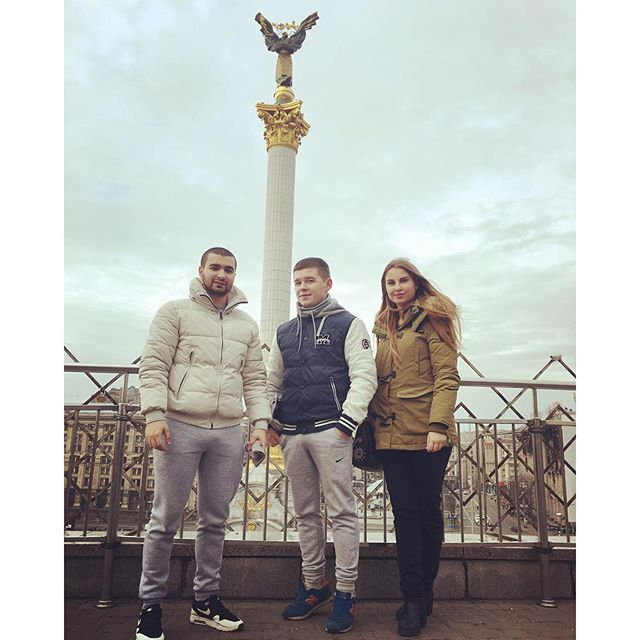

In [15]:
from IPython.display import Image
Image(filename='streetstyle27k/0/7/6/07606eda1f55f4bd894bb2fef4a79a3b_1148467853546919585_989821956.jpg',width=350,height=200) 

The corresponding labels for this image are:

In [9]:
dummy = df[df['img_paths'] == "0/7/6/07606eda1f55f4bd894bb2fef4a79a3b_1148467853546919585_989821956.jpg"].loc[:,["x1","y1","x2","y2","labels"]]
dummy

,x1,y1,x2,y2,labels
6363,271,242,336,372,"Solid,Blue,No,No,nan,Long sleeve,nan,Outerwear..."
6915,186,225,255,365,"Solid,White,No,Yes,No,Long sleeve,Folded,Outer..."
10643,272,242,337,372,"Solid,More than 1 color,No,nan,nan,Long sleeve..."
24338,183,223,258,373,"Solid,nan,No,Yes,No,Long sleeve,Folded,Outerwe..."
25837,364,238,433,378,"Solid,Brown,No,Yes,No,Long sleeve,Folded,Outer..."


In this image, there are 3 people present but 5 associated labels. Upon inspection, it can be seen that 2 of the labels are repetitions (bounding box intersection), referring to the same individual. In the worst case scenario, there are cases where duplicate labels have contrasting labels. For example, the first and third label for this image have different colour categories. With the inclusion of contrasting labels, we are introducing noise into our dataset. With the inclusion of these duplicates in the training/test set we are leaking data which can lead to critical inaccuracies in the model. Therefore, for the time being, we have taken the first label from such images and ignored the rest, yielding a total of 23,908 images. 

For the extraction of further good quality images from duplicate data, please see the Duplicate_detector notebook. 

**Blur Detection**

To improve the quality of the images even further, we introduce a blur criterion to discard low quality images. One method to quantify the amount of blur within an image is to use the variance of the Laplacian filter. The Laplacian of an image highlights regions of rapid intensity change and is therefore often used for edge detection. To calculate this, we apply the convolution 3X3 kernel below to an image and then take its variance. 

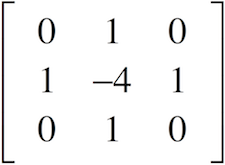

In [21]:
Image(filename='IDWoc.png',width=150)

Intuitively, blurred images with low variance are smooth, have a low spread of response, and this indicates the presence of very little edges. Similarly, high variances corresponds to well focused images. Therefore, images with a variation falling below a predefined threshold can be discarded if need be. For analysis going forward, we will perform classification with and without blue inclusion to see how performance varies.

**Bounding box insertion**

Finally, after gathering the required images, we draw around the provided bounding boxes (provided by StreetStyle) to identify the individual of interest. For this individual, we already have the upper body clothing labels, allowing us to learn a better mapping representation from new unseen labels for the same image. An example of an image after pre-processing is as follows:


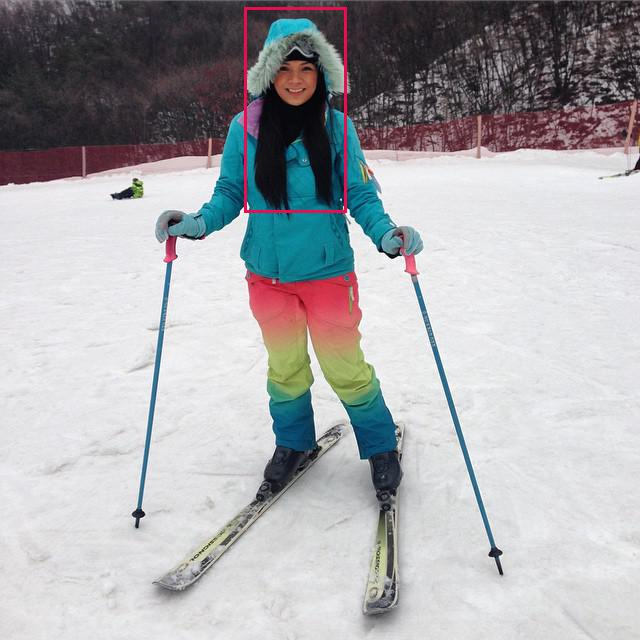

In [29]:
Image(filename='SS_bounded/0a49f9f1493afbe7b620bf4eb10c7a43_899050617791264893_284380717.jpg',width=200)

**Bounding box coverage**

An additional point to note is the coverage of the bounding boxes provided by StreetStyle. After rigorous inspection, it was observed that the bounding boxes provided had poor coverage. They only contain a small region of the target. In some instances, the bounding boxes incorrectly identified a target, enclosing objects/ background entities. We can visualise this further. The following figure shows the StreetStyle bounding box for a chosen image. 


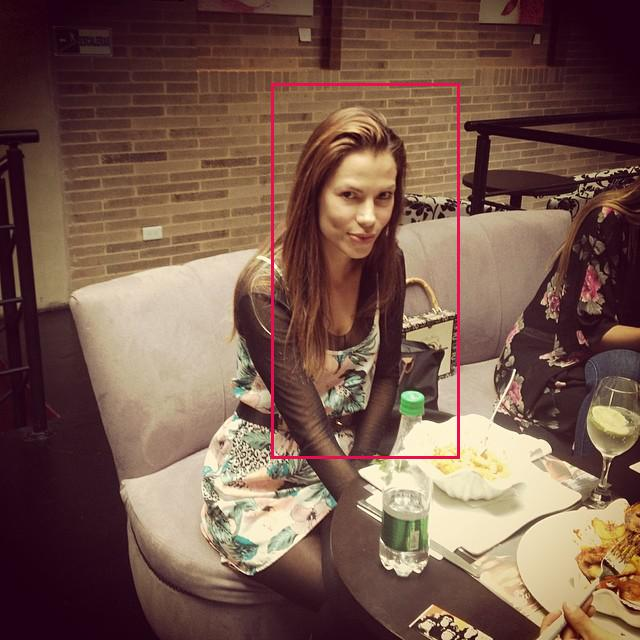

In [33]:
Image(filename='12051bc72e409d4b0b3fd64b59a25911_701687119539582445_676762028.jpg',width=250)

In comparison, we have implemented a people localisation method for the same image. The bounding box for our implementation this as follows: 

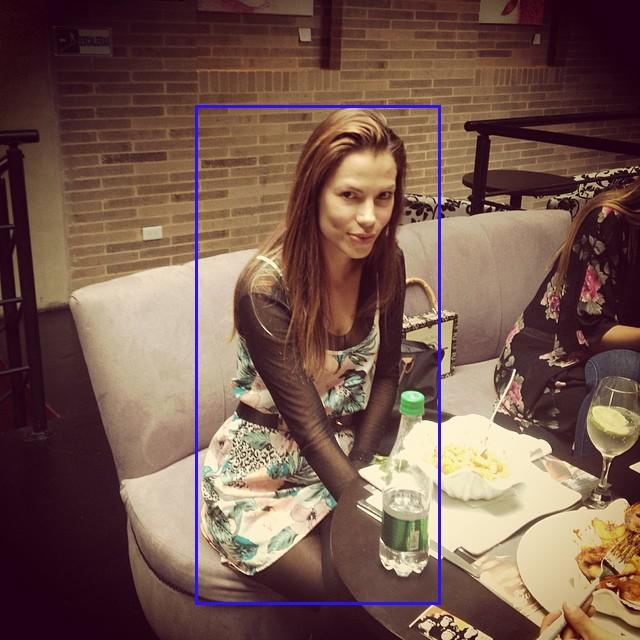

In [34]:
Image(filename='peoplelocal1.jpg',width=250)

In this case, our approach covers a larger area of the dress and less background. It is clear, that this approach encapsulates the required features much more effectively. Consquently, when performing classification on this data, we will apply our own people localisation method to achieve greater accuracies. 